# DLC Postprocess Library

Run after training has been performed, and at least 1 video has been analyzed

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import json
import os

from PyQt5.QtWidgets import QFileDialog
from IPython.display import display, HTML

# import deeplabcut

from lib.parse_dlc_csv import parse_dlc_csv
from lib.constraints import compute_constraints
from lib.plots import plotStatistics
from lib.stickman import stickman
from lib.qt_wrapper import gui_fname, gui_fpath
from lib.sampling import selectUniform

In [3]:
%load_ext autoreload
%autoreload 2

from lib.constraints import likelihood_constrain, velocity_constrain, edge_constrain

### Enter parameters for the analysis of DLC marking

1. **Video File** - The raw video that has been tracked by DLC
2. **Tracking File** - The .CSV file where DLC has put tracking information (usually in the same folder as the raw video after tracking has been done. **Take care to select matching video and tracking file**)
3. **Postprocess Template** - Located in dlc-scripts/scripts/postprocess-templates/. Make one or more templates manually for your individual setup. Template specifies what tracking points will be discarded in the final result, based on: DLC likelihood estimate, velocity of the points (in pixel) and relative edge lengths of edges, defined in the same file.
* **Result Path** - Place where stickman video and filtered tracking data will be written.

In [4]:
pwd_remote="./"
#pwd_remote = "/run/user/1000/gvfs/smb-share:server=130.60.51.15,share=neurophysiology-storage2/Sipila/aaaPDDATA/ALLDATA/TRAININGvideos/"
param = {}
#param["CONF_FNAME"] = gui_fname("Select config file...", "./", "Config Files (*.yaml)")
param["AVI_FNAME"] = gui_fname("Select original video file...", pwd_remote, "Video Files (*.avi)")
tmp_pwd = os.path.dirname(param["AVI_FNAME"])
param["CSV_FNAME"] = gui_fname("Select tracking file...", tmp_pwd, "CSV Files (*.csv)")
param["TMP_FNAME"] = gui_fname("Select Postprocess Template Filename...", "./", "Template Files (*.json)")
param["REZ_FPATH"] = gui_fpath("Select result path", "./")

#print("Using config file", param["CONF_FNAME"])
print("Using original video", param["AVI_FNAME"])
print("Using tracking file", param["CSV_FNAME"])
print("Using template file", param["TMP_FNAME"])
print("Results will be saved in", param["REZ_FPATH"])

Using original video /mnt/neurophys-storage2/Sipila/aaaPDDATA/ALLDATA/TRAININGvideos/2ndTrainingVideoSet/Mouse8DayPost9Reg_2005.01.01_23_57_42.avi
Using tracking file /mnt/neurophys-storage2/Sipila/aaaPDDATA/ALLDATA/TRAININGvideos/2ndTrainingVideoSet/Mouse8DayPost9Reg_2005.01.01_23_57_42DeepCut_resnet50_Tracking4thRoundJun11shuffle1_1030000.csv
Using template file /media/aleksejs/DataHDD/work/codes/image-analysis/behavioural/dlc-scripts/scripts/postprocess-templates/pia-joint-running.json
Results will be saved in /home/aleksejs/Documents/dlc-experiments


In [12]:
#########################
# Parse CSV file
#########################
NODE_NAMES_TRACKED, X, Y, P = parse_dlc_csv(param["CSV_FNAME"])
nFrames, nNodes = X.shape
print("Movie has", nFrames, "frames and", nNodes, "nodes")

#########################
# Parse JSON file
#########################
with open(param["TMP_FNAME"]) as json_file:
    param.update(json.load(json_file))
    
#########################
# Test if template node count match the tracked
#########################
if nNodes != len(param["NODE_NAMES"]):
    raise ValueError("The tracked nodes", NODE_NAMES_TRACKED, "are not consistent with those given in the template file, namely ", param["NODE_NAMES"])
else:
    print("The tracked node names were", NODE_NAMES_TRACKED)
    print("The template node names will be used (order matters):", param["NODE_NAMES"])

Movie has 5408 frames and 5 nodes
The tracked node names were ['Shoulderblade', 'Shoulder', 'Wrist', 'Finger', 'Tip']
The template node names will be used (order matters): ['ShoulderBlade', 'Shoulder', 'Wrist', 'Finger', 'Tip']


### Analyse data, compute and plot results

Determine frames, that
* Have low confidence based on DLC self-reported analysis
* Do not fulfill node constraints (e.g. excessive velocity)
* Do not fulfill edge constraints (e.g. too large or too small edges)

(5408, 5) (5407, 5)
bool bool
(5408, 5) (5408, 5)
Average lengths of edges are [137.10637285 187.33164352  33.9130741   54.70780798]


,All the above combined,Edges too long or short,High velocity 1 neighbour,High velocity 2 neighbours,Low confidence
Nodes,1049,1018,75,15,1006
Frames,1014,983,50,12,983


<IPython.core.display.Javascript object>


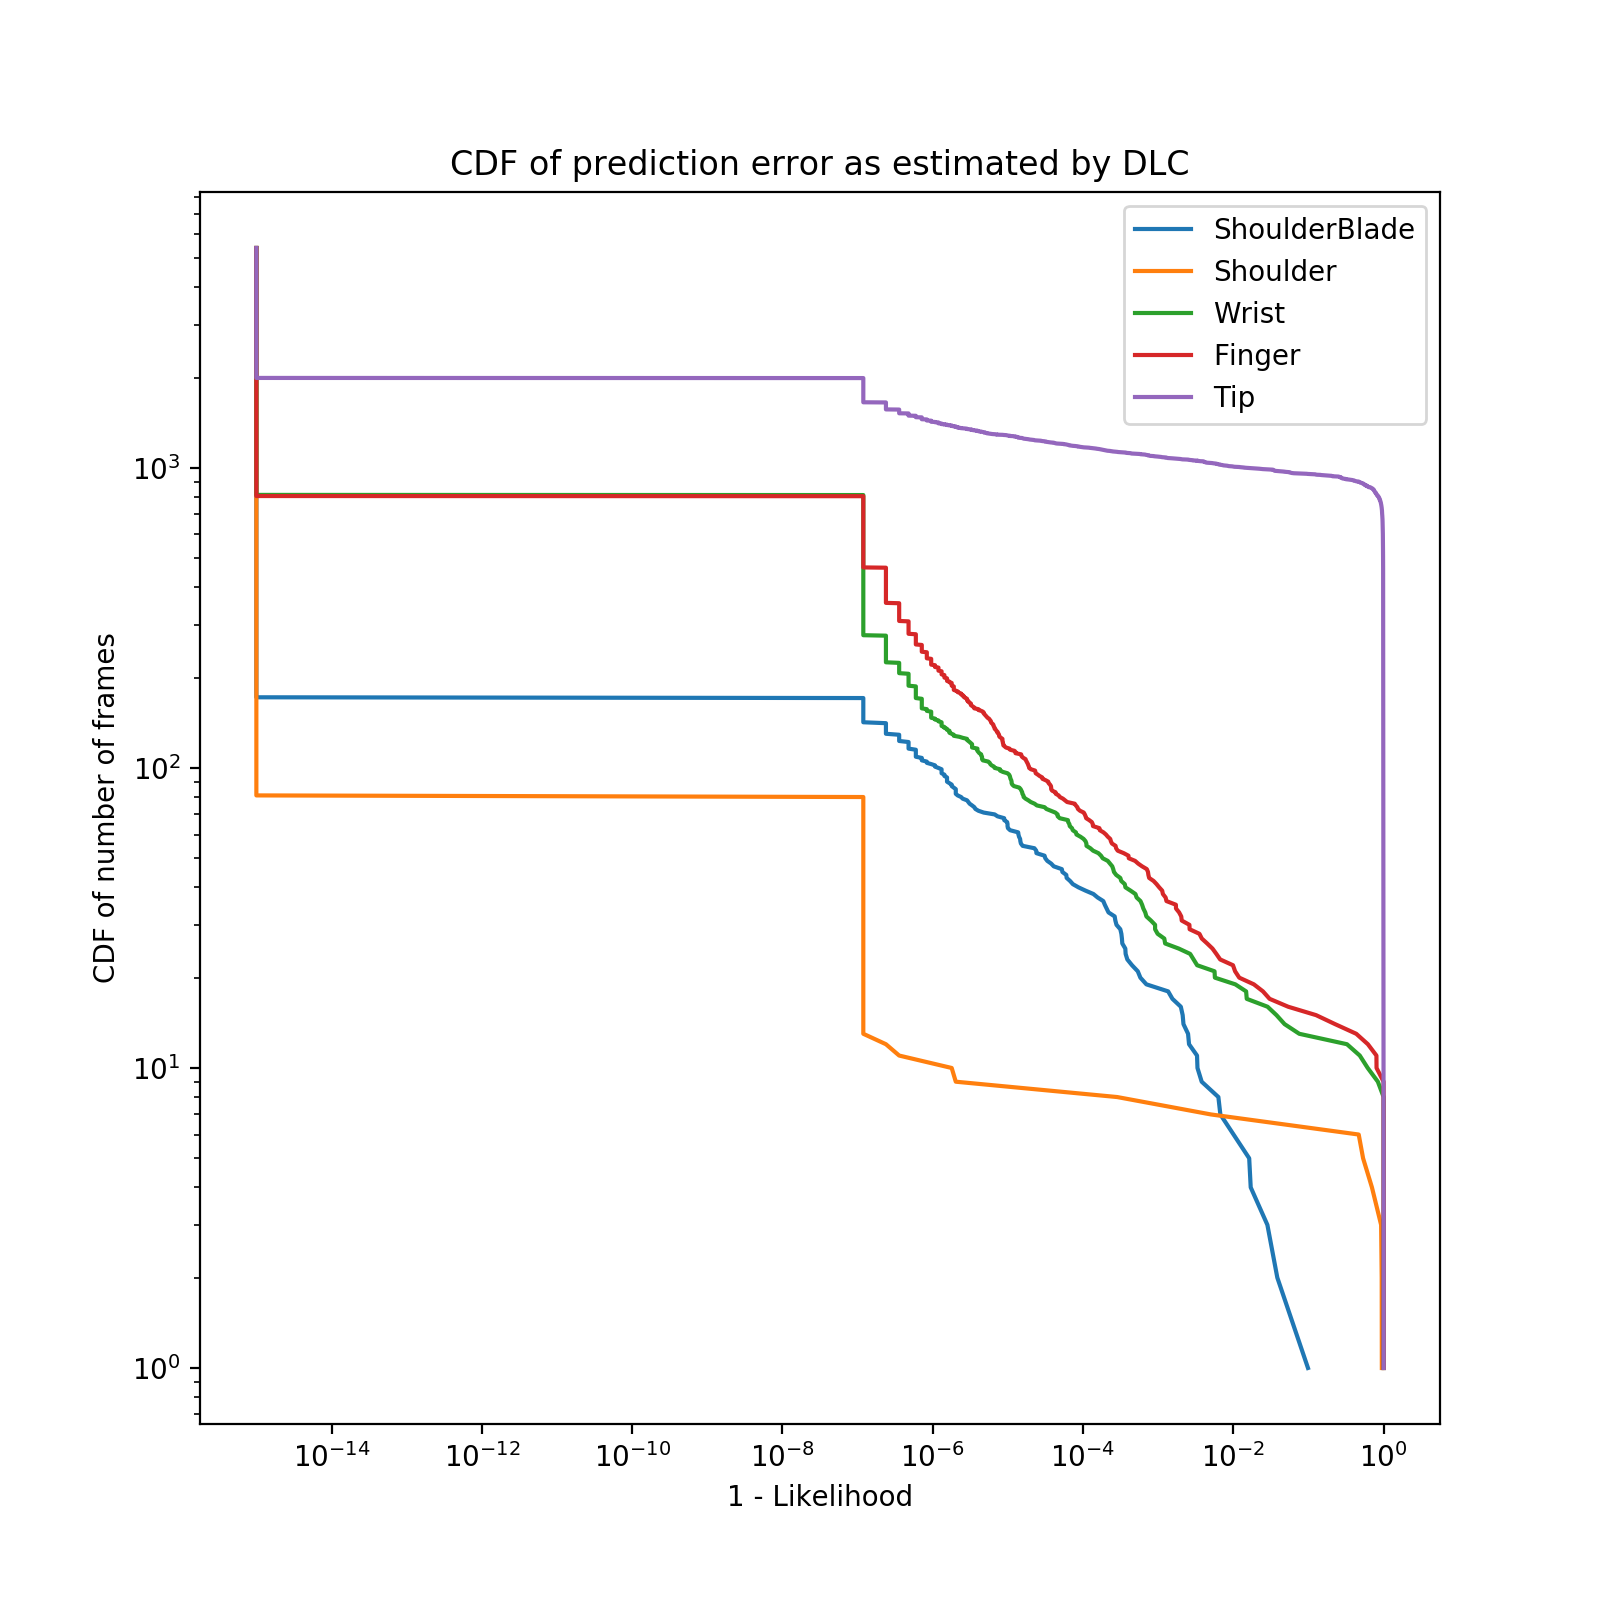

<IPython.core.display.Javascript object>


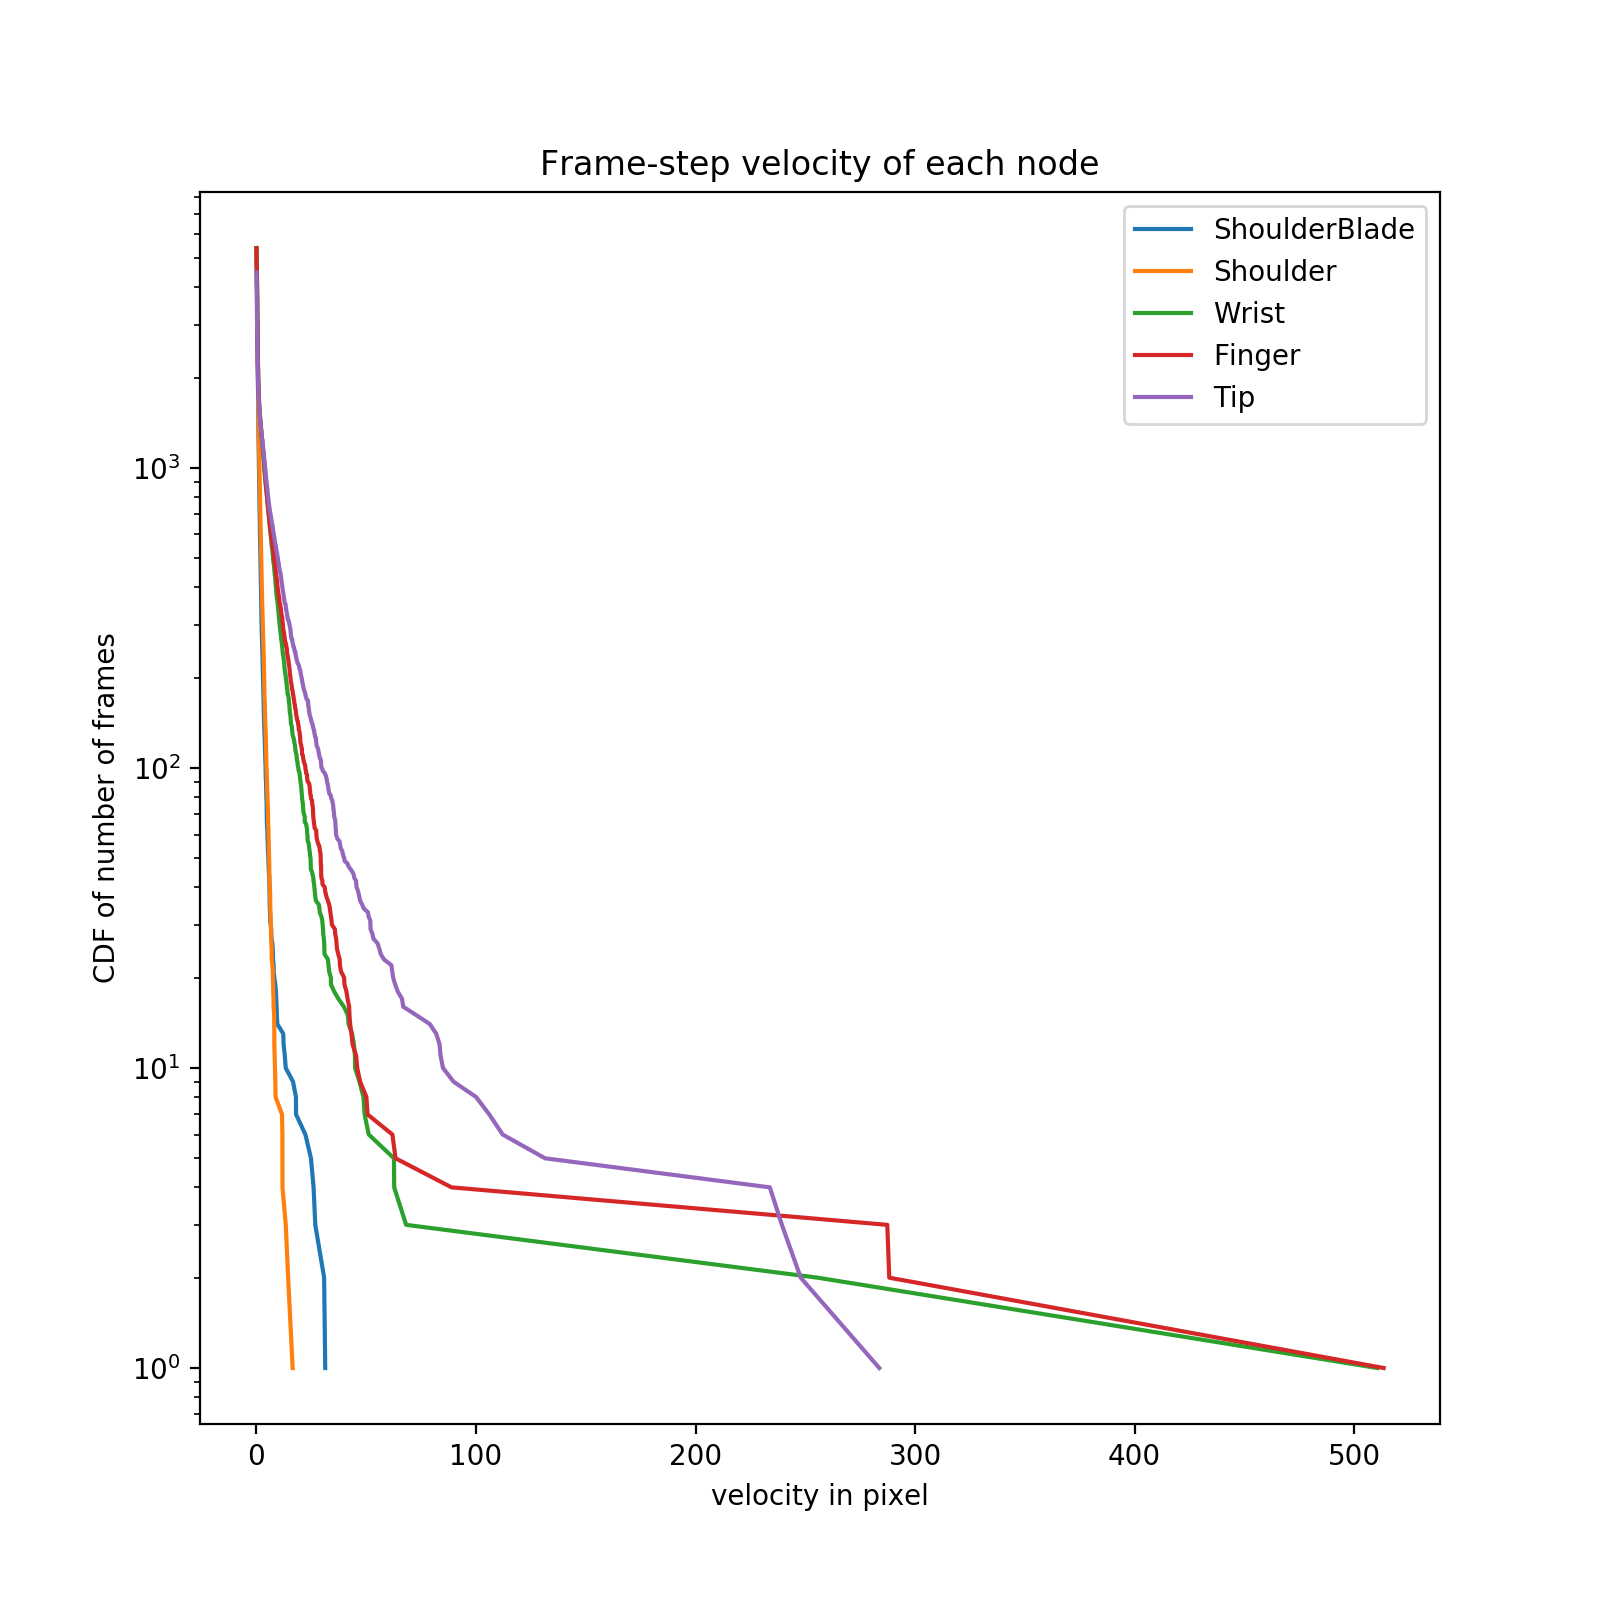

<IPython.core.display.Javascript object>


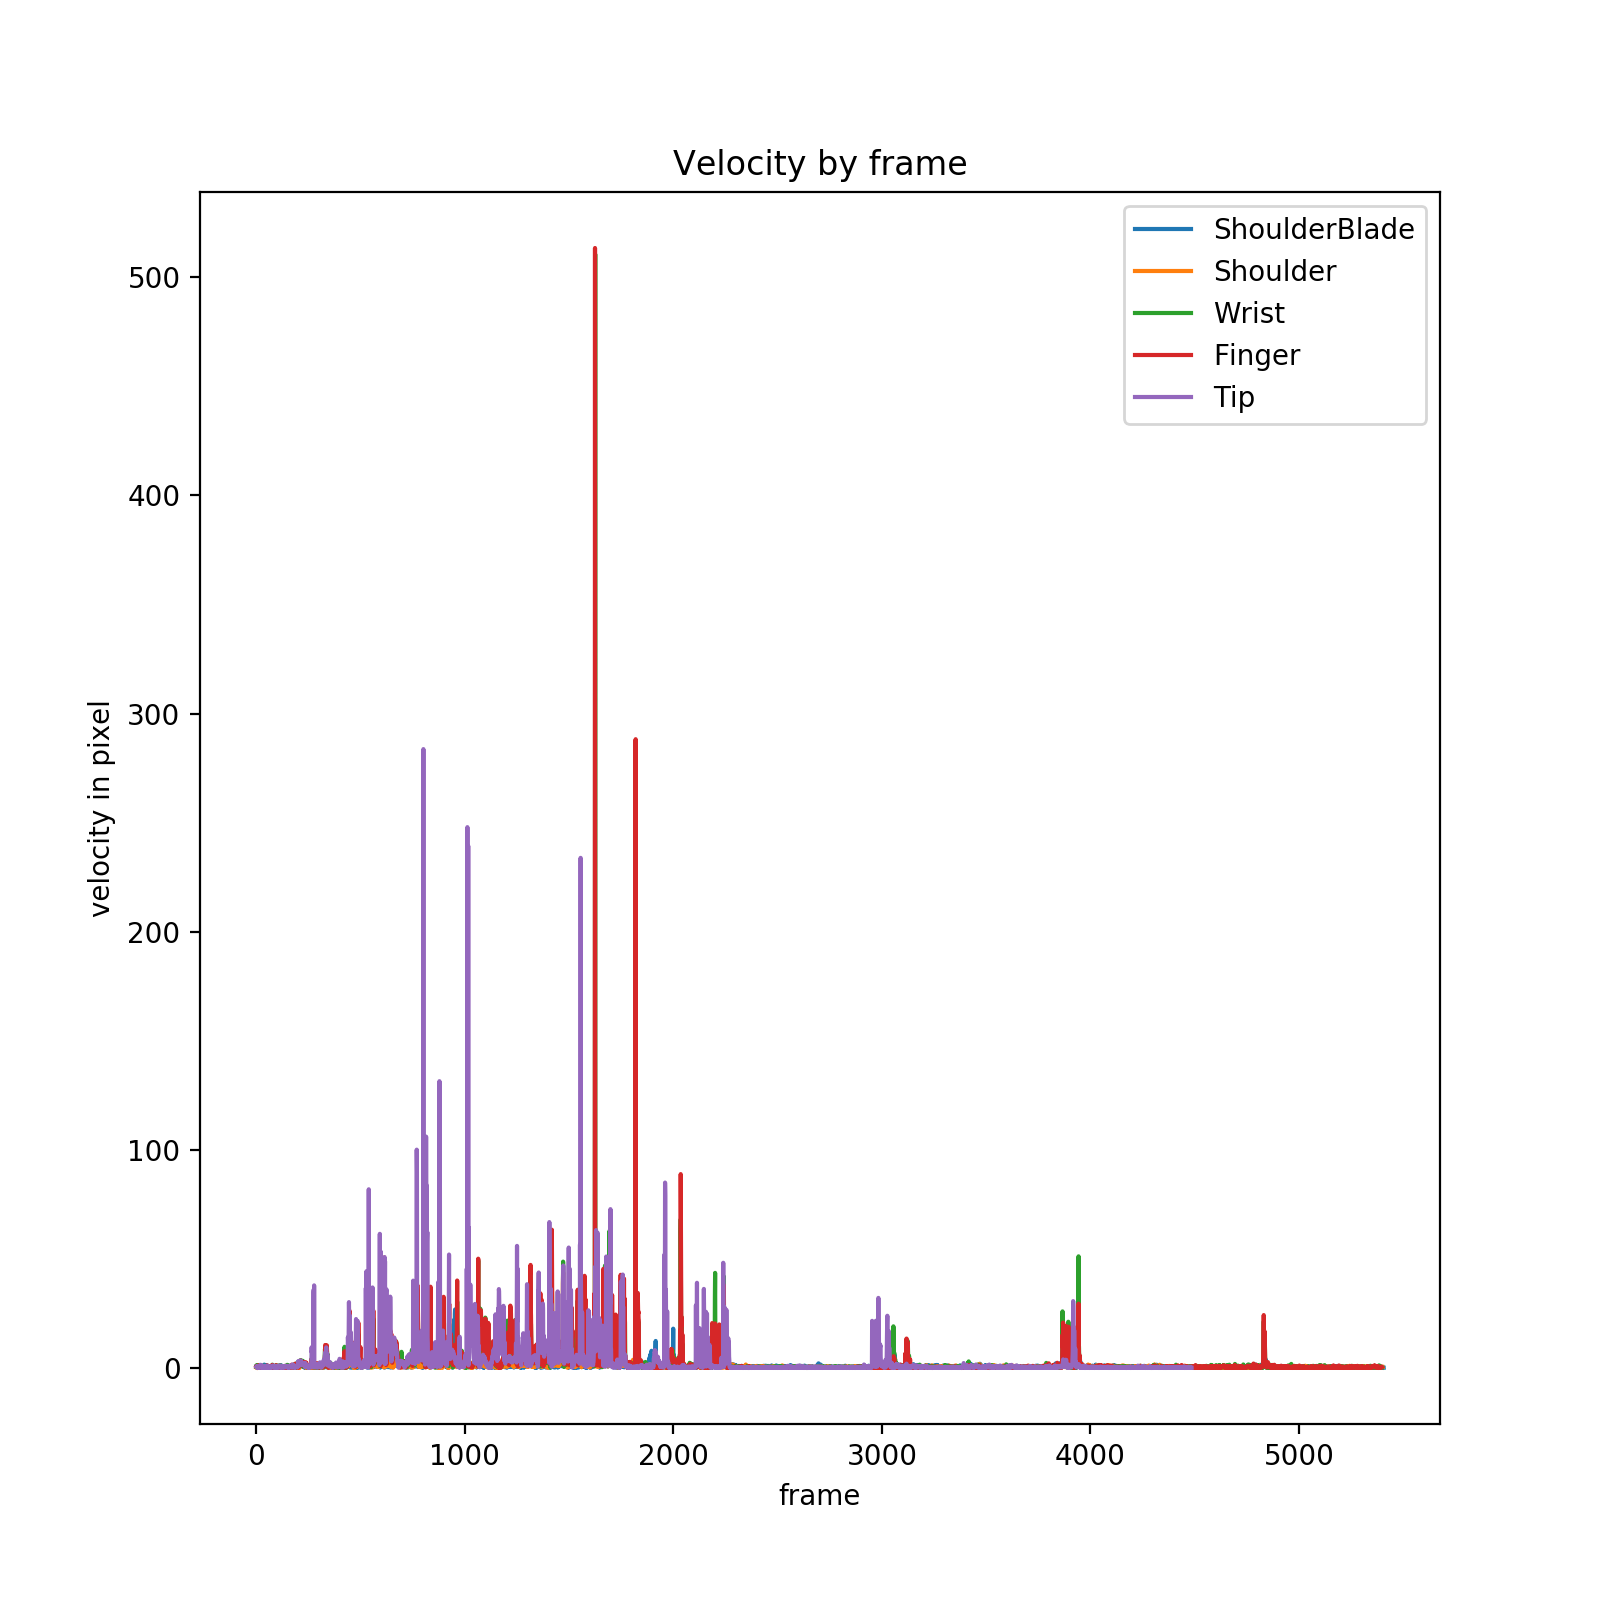

<IPython.core.display.Javascript object>


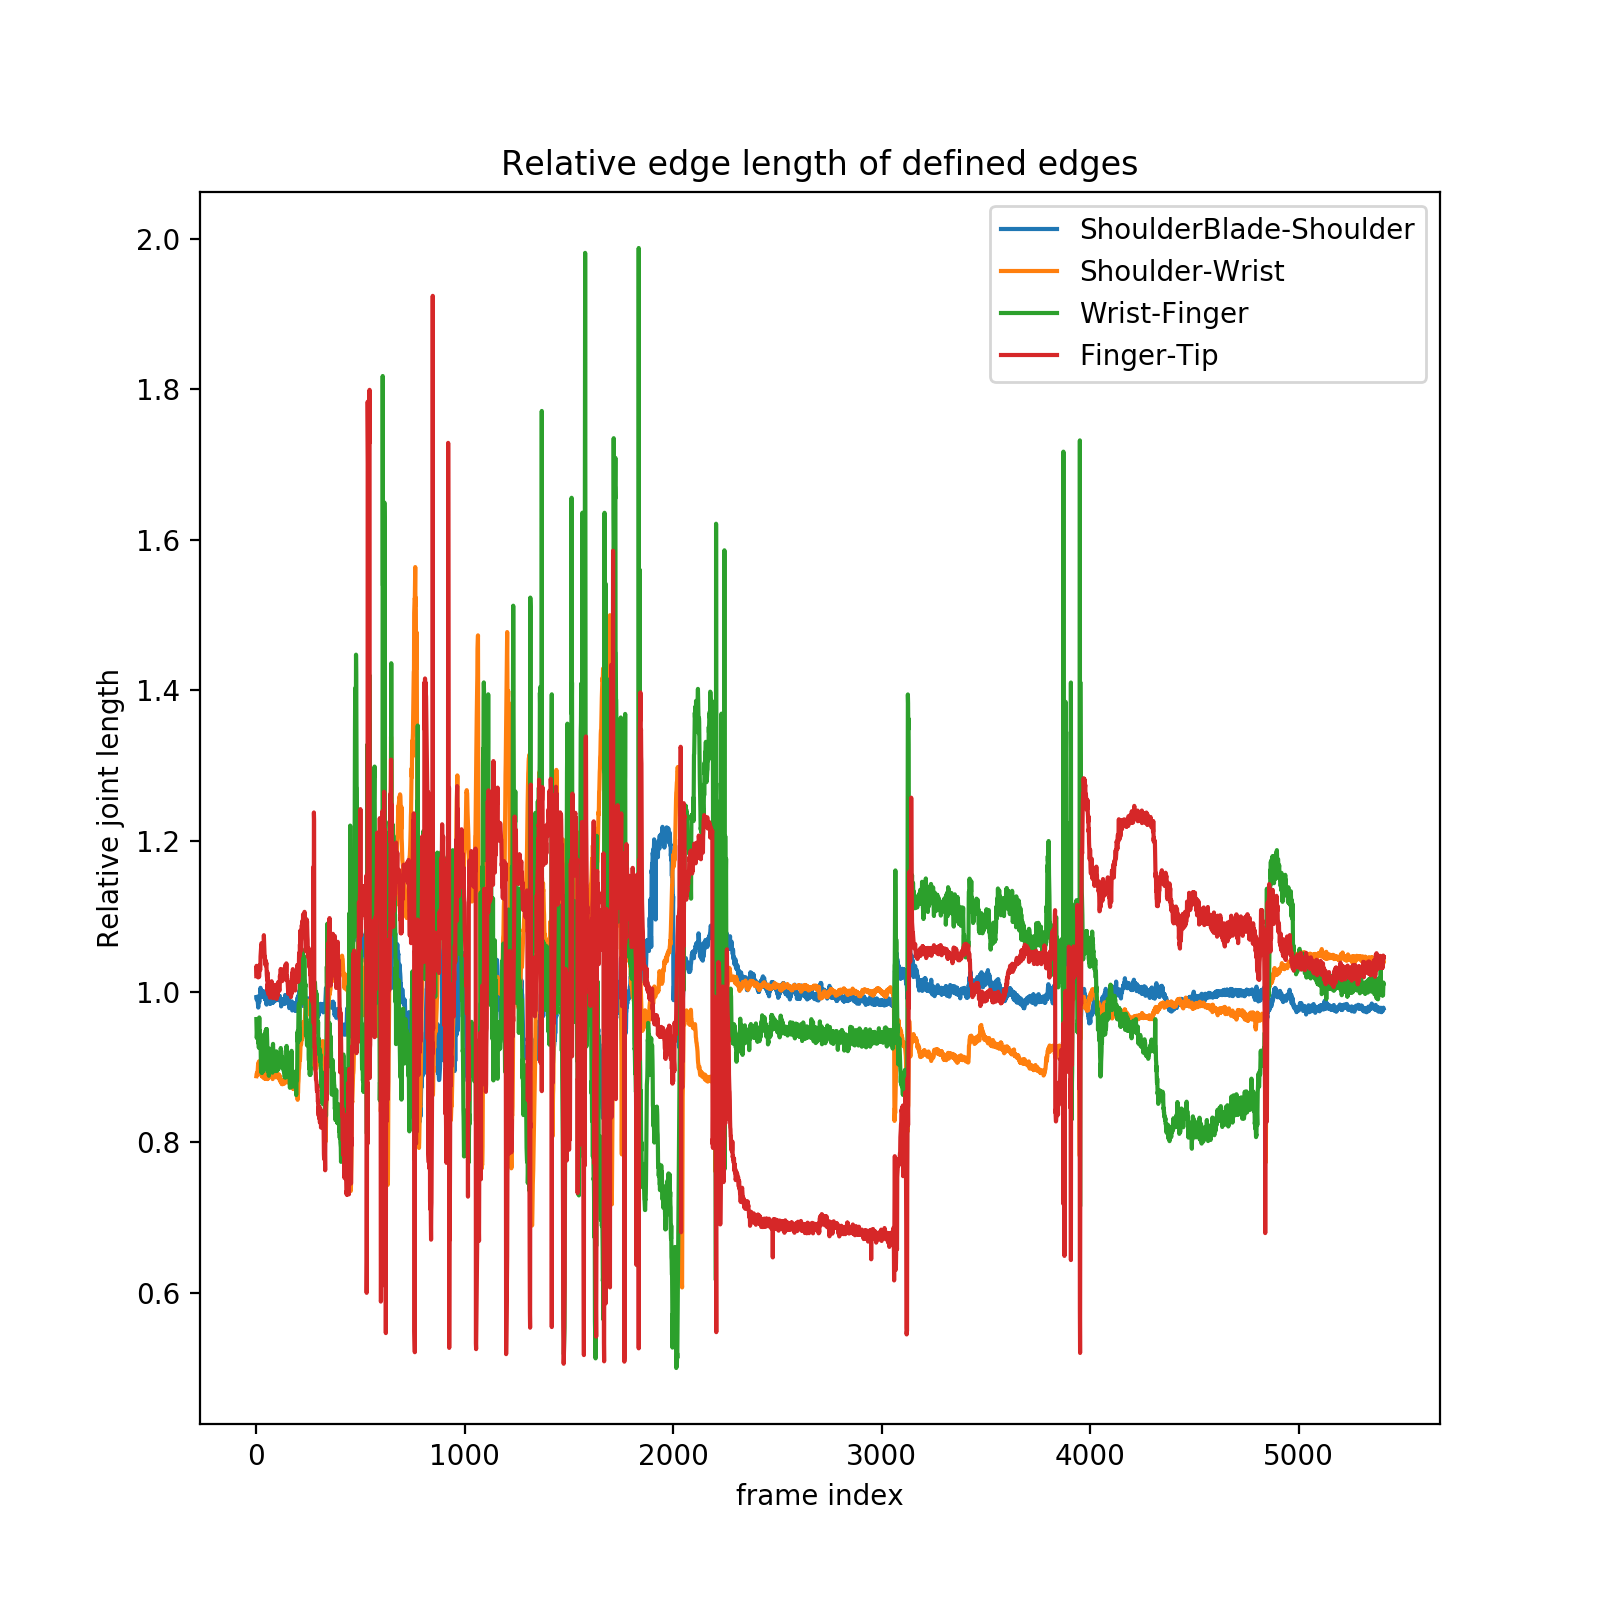

In [37]:
%matplotlib notebook
    
# Compute Constraints
constr_dict = compute_constraints(X, Y, P, param)
display(constr_dict["summary"])

# Plot Statistics
plotStatistics(param, constr_dict)

### Create stickman video and write it to file

In [40]:
#########################
# Make Stickman Video
#########################
stickman(X, Y, param, constr_dict)

Writing video [5408/5408]
Done!


# Training-Only

### Decide which frames will be selected for manual marking

1. Check which constraints are present
2. Merge constraints to decide which frames are bad, possibly rank them
3. Extract numbers of frames that are bad
4. Subsample fixed amount randomly, possibly rank-biased
5. Extract actual frames, save as images 

**TODO**:
* Rank-based selection
* Clustering-based selection

In [9]:
frameIdxs = np.linspace(1, nFrames, nFrames).astype(int)
frameIdxsBad = frameIdxs[framesBadTotal]
nBadFrames = len(frameIdxsBad)

# Option 1: Select all bad frames
# selectedFrames = frameIdxsBad

# Option 2: Select fixed amount of bad frames uniformly
selectedFrames = frameIdxsBad[selectUniform(nBadFrames, 40)]

print("Selected frames are", selectedFrames)

AttributeError: module 'numpy' has no attribute 'quantile'

### Extract actual frames from the video, save them to the tracking folder

**TODO**:
* Inspect DLC outlier selection, perhaps can reuse functionality

In [ ]:
deeplabcut.extract_outlier_frames(path_config_file, [param["AVI_FNAME"]])

## Create new training dataset

In [ ]:
deeplabcut.create_training_dataset(path_config_file)

# Tracking-Only
### Post-tracking marking

**TODO**
1. Run DLC_GUI on all selected frames
2. Open resulting file, merge markings with current markings

### Finalizing

1. Mark all unconfident or unconstrained data as NAN
2. Save data to file

In [10]:
# Set all bad coordinates to NAN
X[framesBadTotal, :] = np.nan
Y[framesBadTotal, :] = np.nan

rez_fname_h5 = os.path.join(param["REZ_FPATH"], "result.h5")
print("Writing tracking data to", rez_fname_h5)
rezfile = h5py.File(rez_fname_h5, "w")
rezfile['NODE_NAMES'] = param['NODE_NAMES']
rezfile['X'] = X
rezfile['Y'] = Y
rezfile.close()

Writing tracking data to //hifosrdc09/Workspace/Neurophysiology-Storage2/Sipila/aaaPDDATA/ALLDATA/Projects-DLC-Training/Tracking2ndRound-Pia-2019-06-05/results\result.h5


TypeError: No conversion path for dtype: dtype('<U13')